In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
batch_size = 1024
block_size = 128

vocab_size = 256
num_embed = 192
num_head = 6
num_layer = 6

### Data loader

In [3]:
train = np.memmap("train.bin", dtype=np.uint8, mode="r")

In [4]:
def get_batch():
    indices = torch.randint(len(train) - block_size, (batch_size,))
    X = torch.stack([torch.from_numpy((train[i:i+block_size]).astype(np.int64)) for i in indices]).to('cuda')
    Y = torch.stack([torch.from_numpy((train[i+1:i+1+block_size]).astype(np.int64)) for i in indices]).to('cuda')
    return X, Y

### Model definition

In [5]:
class MlpBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_embed, 4 * num_embed)
        self.fc2 = nn.Linear(4 * num_embed, num_embed)
        self.gelu = nn.GELU()

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm1 = nn.LayerNorm(num_embed)
        self.attn = nn.MultiheadAttention(num_embed, num_head, batch_first=True)
        self.norm2 = nn.LayerNorm(num_embed)
        self.mlp = MlpBlock()
        self.register_buffer("attn_mask", nn.Transformer.generate_square_subsequent_mask(block_size).to('cuda'))

    def forward(self, x):
        x_length = x.shape[1]
        
        normalized_x = self.norm1(x)
        x = x + self.attn(normalized_x, normalized_x, normalized_x, attn_mask=self.attn_mask[:x_length, :x_length])[0]
        x = x + self.mlp(self.norm2(x))
        return x

class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, num_embed)
        self.position_embedding = nn.Embedding(block_size, num_embed)
        self.blocks = nn.Sequential(*[DecoderBlock() for _ in range(num_layer)])
        self.norm = nn.LayerNorm(num_embed)
        self.head = nn.Linear(num_embed, vocab_size, bias=False)

    def forward(self, x):
        x_length = x.shape[1]
        positions = torch.arange(0, x_length, dtype=torch.long)[None,:].to('cuda')
        token_x = self.token_embedding(x)
        position_x = self.position_embedding(positions)
        x = token_x + position_x
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x)
        return x

In [6]:
x, y = get_batch()
model = GPT().to('cuda')
output = model(x)
bytes(torch.argmax(output, dim=-1)[0])

b'T\xcb\x03Y\xffz\xa5\xa74S\n\xac\x967>\n\x96\xf9\xa8\xae\x14\x18"\x8fwS\xf5x\xcd\xe8\x15b\x08\xeb_i]\xff(\x11\xff\xec\x86\xf5\x96\x96\x93\x99\x86F{\x1f\tu\xff\xfb\x95O\xc6\x8c\x96 [\xff\x98P\x13\x9dd\xb0\xdc\xd0\xdc\xec\xf8\xaf\x96i\xa5\xaf\x1a\xbe\x96\xd2\x96\xff\xd7\x9d\xfa\xcd\n\xea\xf7\x88\xda\x17\xfb\xf0\x8cnAY\x87\xff\xdbs\xcb\xa1\xa0\xeb\x92\x95\xcb\'\xff/+\x96\xdb\xefy\xe9\xfa- \xdbq\xd3'

In [6]:
def calc_loss(logits, target):
    return F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1))

### Implementing learning rate finder

In [7]:
model = GPT().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [8]:
min_loss = 1e9
lrs = []
losses = []
while True:
    optimizer.zero_grad()
    x, y = get_batch()
    loss = calc_loss(model(x), y)
    current_loss = float(loss)
    min_loss = min(min_loss, current_loss)
    if min_loss*3 < current_loss:
        break
    lrs.append(scheduler.get_last_lr()[0])
    losses.append(current_loss)
    if len(lrs) % 20 == 0:
        print("loss = %f lr = %f" % (losses[-1], lrs[-1]))
    loss.backward()
    optimizer.step()
    scheduler.step()

loss = 3.518911 lr = 0.014619


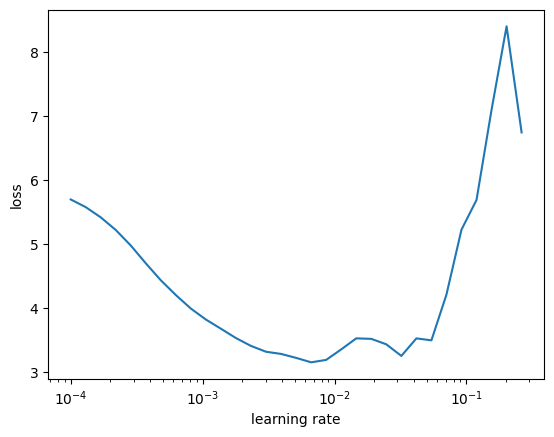

In [9]:
plt.plot(lrs, losses)
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.xscale('log')
plt.show()

### Training loop

In [8]:
model = GPT().to('cuda')
total_steps = 30000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-4, total_steps=total_steps)

In [11]:
for i in (pbar := tqdm(range(26022, total_steps))):
    optimizer.zero_grad()
    x, y = get_batch()
    loss = calc_loss(model(x), y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    pbar.set_description("lr = %f loss = %f" % (scheduler.get_last_lr()[0], loss))
    
    if i > 0 and i % 3000 == 0:
        torch.save({
            'step': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,
            }, "ckpt-%d" % i)

lr = 0.000000 loss = 1.287202: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3978/3978 [20:53<00:00,  3.17it/s]


In [12]:
torch.save({
    'step': total_steps,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,
    }, "ckpt-%d" % total_steps)

In [14]:
# x, y = get_batch()
output = model(torch.tensor([c for c in "articl".encode("utf-8")])[None,:].to('cuda'))
bytes(torch.argmax(output, dim=-1)[0])

b'nt sle'

In [17]:
torch.argmax(output, dim=-1)[0]

tensor([104, 101,  32,  97, 101, 114, 101, 108,  32, 115, 116,  32, 111,  97,
        115,  32,  97, 111, 114, 110,  32, 105, 110,  32, 116],
       device='cuda:0')

In [28]:
cur = [c for c in "I'm not a cat, ".encode("utf-8")]
for i in range(32):
    output = model(torch.tensor(cur)[None,:].to('cuda'))
    cur.append(int(torch.argmax(output, dim=-1)[0, -1]))
print(bytes(cur))

b"I'm not a cat, and the song was released on the"


In [30]:
cur = [c for c in "Murasaki Shikibu is".encode("utf-8")]
for i in range(128 - len(cur)):
    output = model(torch.tensor(cur)[None,:].to('cuda'))
    probs = F.softmax(output[0, -1, :], dim=0)
    cur.append(int(torch.multinomial(probs, num_samples=1)))
print(bytes(cur).decode("utf-8"))

Murasaki Shikibu is a homeland in Japan, including Kilstone, Wales, Tokyo, Sarah Kanagara, Tophong, King, Janot, and Saunders. T
